<h1 style="text-align: center;">Climate data in python practical</h1>
<p style="text-align: center;"><i>ERCA 2023 - Rémy Lapere</i></p>

In this tutorial we will:
> Load `CMIP6` climate data directly into python through `Pangeo` <br />
> Use `xarray` and `pandas` to manipulate the data (selection, averaging, resampling, interpolation...) <br />
> Plot fancy maps with custom colorbars <br />
> Learn that you can easily download `Copernicus` data through their python API <br />
> Bonus: make your data sing

Some of the python libraries we will need are not readily available on the UGA `Jupyterlab` and need to be installed first. You can either do that from the terminal or run the cell below.

In [5]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install xarray
#!{sys.executable} -m pip install miditime
#!{sys.executable} -m pip install intake
#!{sys.executable} -m pip install aiohttp
#!{sys.executable} -m pip install requests
#!{sys.executable} -m pip install gcsfs
#!{sys.executable} -m pip install pygame
#!{sys.executable} -m pip install python-vlc

First thing to do in `Python`: load the libraries that will be useful for our project.

In [16]:
%load_ext autoreload
%autoreload 2

In [36]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.path as mpath
import warnings
import cartopy
import cartopy.crs as ccrs
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})

from functions import *

<h1 style="text-align: center;">SECTION 1: load climate data from Pangeo</h1>

Pangeo is `A community platform for Big Data geoscience` (https://pangeo.io/) which, among other things, provides access to data catalogs such as `CMIP6` output. Using the associated python libraries is a powerful tool for the analysis of climate data without ever having to download and store them.

The workflow I recommend for this use is:
1. Assess the existence of the `CMIP6` data you are interested in through the ESGF platform (https://esgf-node.ipsl.upmc.fr/search/cmip6-ipsl/). I recommend using the `CMIP6` data catalog (https://clipc-services.ceda.ac.uk//dreq/mipVars.html) for better understanding of the variable names and contents
2. Once you have identified the data sets you want on `ESGF`, apply the associated filters in the scripts below when searching the `Pangeo` catalog

In [18]:
# connect to the pangeo storage catalog
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [19]:
# select the data set we want to investigate
# in this example, we are looking at monthly surface temperature in one CMIP6 model
# we do a search through the pangeo catalog using the appropriate keys
cat = col.search(variable_id=['tas'], 
                 member_id=['r1i1p1f1'],
                 source_id=['NorESM2-MM'],
                 experiment_id=['historical'],
                 table_id=['Amon'])

In [20]:
# make a dictionary from the catalog
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [21]:
# list the available keys in the dictionary to make sure we got what we wanted
dataset_list = list(dset_dict.keys())
dataset_list

['CMIP.NCC.NorESM2-MM.historical.Amon.gn']

In [53]:
# select the element we are looking for
# in this case there is only one but you can load several data sets at once
# e.g. if you also want precipitation, variable_id=['tas'] above becomes variable_id=['tas','pr']
dset = dset_dict[dataset_list[0]].chunk(chunks={'time':20,'lat':10,'lon':10})
# if you want to use a dataset that you have locally, 
# you can equivalently load the data into xarray with xr.open_dataset() and start from here
dset

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, member_id: 1, time: 1980)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(10, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(10, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(20, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 20, 10, 10), meta=np.ndarray>
Attributes: (12/54)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1200-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     438000.0
    ...                        ...
    variable_id:               tas
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/b726dcce-04e7-41ef-8f32-a36cffa51...
    version_id:                v20191108
    intake_esm_varname:        ['tas']
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-MM.historical.Amon.gn

<h1 style="text-align: center;">SECTION 2: select, manipulate, resample...</h1>

The data previously loaded is "stored" in an `xarray` dataset. This is probably the most convenient way to deal with large data sets in `Python` as the data is not fully loaded in cache as `numpy`-based libraries would do. As a result, all the manipulations on the data (averaging, resampling...) are very fast. If you haven't yet, I highly recommend you make the switch to `xarray` if you manupilate `netcdf` files regularly. It could change your life (no exaggeration).

You don't have to take my word for it, just try it yourself with the following examples. If you are curious, you can convert the `xarray` dataset used here into a `numpy` and try to make the same manipulations so you can compare computing times.

In [71]:
# select a given range of latitude/longitude using the .sel() method of xarray
# here we select for europe approximately 
# feel free to change to whatever region you'd like to study
# note that I apply squeeze after transformations to get rid of the "useless" coordinates

tas_eur = dset.sel(lat=slice(30,70)).squeeze()

tas_eur = tas_eur.where((tas_eur.lon>=335.0) | (tas_eur.lon<=45.0), drop=True)

# use the .mean() method of xarray to spatially average over the selected domain
tas_eur_avg = tas_eur.mean(dim=('lat','lon')).squeeze()

# use the .resample() method to aggregate data from monthly to annual
# and apply the .max() method to get the annual maximum
tas_eur_yearly_max = tas_eur.resample(time='1Y').max().squeeze()

<h1 style="text-align: center;">SECTION 3: make nice plots!</h1>



## 3.1: plot a map with custom colorbar


In [72]:
# let's say we want to plot the average monthly surface air temperature
# - for NH summer months only
# - for the years 1980 to 2010 only
tas_jja = dset.sel(time=dset['time.season']=='JJA')
tas_jja_1980_2010 = tas_jja.sel(time=slice('1980','2010'))
tas_mean_jja_1980_2010 = tas_jja_1980_2010.tas.mean(dim='time').squeeze()

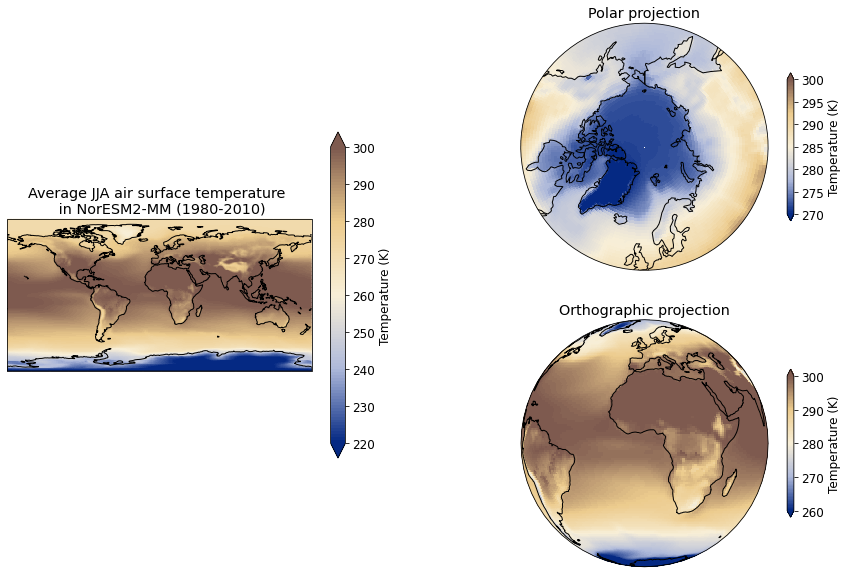

In [74]:
cmap_GoldenTheo = build_cmap('GoldenTheo', 
        [(5/256, 41/256, 132/256),(175/256, 186/256, 219/256),
        (249/256, 240/256, 216/256),(237/256, 204/256, 142/256),
        (126/256, 90/256, 79/256)])


fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax1.set_extent([-180,180,-90,90], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(1,1,1,0))
ax1.set_title('Average JJA air surface temperature \n in NorESM2-MM (1980-2010)')

c1 = ax1.pcolormesh(tas_mean_jja_1980_2010.lon,
                    tas_mean_jja_1980_2010.lat,
                    tas_mean_jja_1980_2010,
                    cmap = cmap_GoldenTheo,
                    vmin = 220,
                    vmax = 300)

plt.colorbar(c1, shrink=0.6, label='Temperature (K)', extend='both')

ax2 = plt.subplot(2,2,2,projection=ccrs.NorthPolarStereo())
ax2.set_extent([-180,180,50,90], ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(1,1,1,0))
ax2.set_title('Polar projection')
theta = np.linspace(0, 2*np.pi, 100)                                                                                                                                                                       
center, radius = [0.5, 0.5], 0.5                                                                                                                                                                           
verts = np.vstack([np.sin(theta), np.cos(theta)]).T                                                                                                                                                        
circle = mpath.Path(verts * radius + center)                                                                                                                                                               
ax2.set_boundary(circle, transform=ax2.transAxes) 

c2 = ax2.pcolormesh(tas_mean_jja_1980_2010.lon,
                    tas_mean_jja_1980_2010.lat,
                    tas_mean_jja_1980_2010,
                    cmap = cmap_GoldenTheo,
                    vmin = 270,
                    vmax = 300,
                    transform=ccrs.PlateCarree())

plt.colorbar(c2, shrink=0.6, label='Temperature (K)', extend='both')


ax3 = plt.subplot(2,2,4,projection=ccrs.Orthographic())
ax3.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(1,1,1,0))
ax3.set_title('Orthographic projection')

c3 = ax3.pcolormesh(tas_mean_jja_1980_2010.lon,
                    tas_mean_jja_1980_2010.lat,
                    tas_mean_jja_1980_2010,
                    cmap = cmap_GoldenTheo,
                    vmin = 260,
                    vmax = 300,
                    transform=ccrs.PlateCarree())

plt.colorbar(c3, shrink=0.6, label='Temperature (K)', extend='both')


plt.show()

<h1 style="text-align: center;">SECTION 4: interpolate and compare to observations</h1>

In this section, we will compare the `CMIP` simulated temperature to observed data in Santiago, Chile (because... why not). This will require spatial interpolation, which can be nicely done with `xarray`

In [45]:
# hourly surface temperature measured in Santiago, Chile, for 2004-2021
# downloaded from SINCA (https://sinca.mma.gob.cl/) on Dec. 20, 2022
# we use pandas read_csv method to open the input file
obs = pd.read_csv('Temp_Santiago_hourly_2004-2021.csv',
                  header=0,
                  sep=',',
                  index_col=False,
                  parse_dates=['Time'])

# take only until 2014 to match CMIP period
obs = obs[obs.Time.dt.year<=2014]

# hourly data to monthly mean
obs["Month"] = obs.Time.dt.month
obs_monthly = obs.groupby(['Month'],as_index=False).mean()

# take only 2004-2014 to match the observation period and groupby monthly mean
temp_santiago_cmip = dset.sel(time=slice('2004','2014'))
temp_santiago_cmip_monthly = temp_santiago_cmip.groupby(temp_santiago_cmip.time.dt.month).mean().squeeze()

# CMIP data interpolated at the Santiago grid point with "nearest neighbor" method
# There are several interpolation methods in xarray, go check them out they can be very useful
# for example if you want to compare 2 maps that are on different grids and make a difference map
# this can be done with xarray interp_like() method (see also section 6 later)
temp_santiago_cmip = temp_santiago_cmip_monthly.interp(lat=[-33.5],lon=[360-70.65],method='nearest')

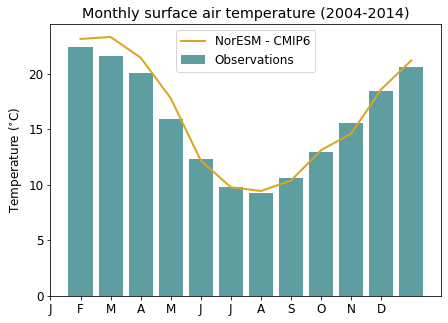

In [39]:
fig = plt.figure(figsize=(7,5))

plt.bar(obs_monthly.Month,
        obs_monthly.Temp,
        color='cadetblue',
        label='Observations')

plt.plot(temp_santiago_cmip_monthly.month,
         temp_santiago_cmip_monthly.tas-273.15,
         linewidth=2,
         color='goldenrod',
         label='NorESM - CMIP6')

plt.xticks(range(12),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.ylabel('Temperature ($^{\circ}$C)')
plt.title('Monthly surface air temperature (2004-2014)')
plt.legend()
plt.show()

<h1 style="text-align: center;">SECTION 6: Copernicus data</h1>

`Copernicus` data such as `ERA5` (climate reanalysis) or `CAMS` (air quality reanalysis) are available through the `Copernicus Climate Data Store` (https://cds.climate.copernicus.eu/).

A very interesting feature is that they provide the possibility to download the data via their web API, or through a `python` API, which you can run as a script from any server you might use for your work. For the latter option, they provide a tutorial here: https://cds.climate.copernicus.eu/api-how-to. This is a very convenient way to obtain the data. We won't do this here because the setup requires that you create an account and generate an API key, but I strongly recommend you have a look on your own if you are using Copernicus data in the future.

For the next exercise I already downloaded the monthly reanalysis of surface temperature from `ERA5`. As an illustration for the interpolation capabilities of `xarray`, we will make a difference map between `CMIP` and `ERA5` values, using the `interp_like()` method from `xarray`.

In [67]:
# open ERA5 temperature data set and rename fields to CMIP convention for the interpolation
era5 = xr.open_dataset('ERA5_monthly_temp_2004_2014.nc')
era5 = era5.rename({'latitude':'lat','longitude':'lon','t2m':'tas','time':'Time'})

# select only 2004-2014 in CMIP and drop useless dimension/attributes
dset_ = dset.sel(time=slice('2004','2014')).squeeze()
dset_ = dset_.drop(['height','lat_bnds','lon_bnds','member_id','time_bnds'])

# warning: here CMIP and ERA5 use different time conventions. CMIP January is 01/16, ERA5 January is 01/01.
# that's why I renamed the 'time' dimension in ERA5, to make it different so that interp_like() does not
# try to interpolate on this dimension. Otherwise you get NaN values.
# after interpolation I do the reverse operation and affect the CMIP time to ERA5
# to ease manipulation in the continuation
era5_interp = era5.interp_like(dset_)
era5_interp = era5_interp.rename({'Time':'time'})
era5_interp['time'] = dset_['time']

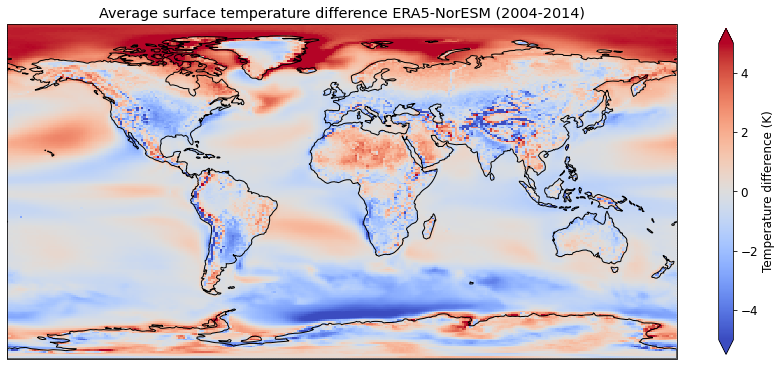

In [69]:
diff_era_cmip = (era5_interp - dset_).mean(dim='time')

fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax1.set_extent([-180,180,-90,90], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(1,1,1,0))
ax1.set_title('Average surface temperature difference ERA5-NorESM (2004-2014)')

c1 = ax1.pcolormesh(diff_era_cmip.lon,
                    diff_era_cmip.lat,
                    diff_era_cmip.tas,
                    cmap = 'coolwarm',
                    vmin = -5,
                    vmax = 5)

plt.colorbar(c1, shrink=0.6, label='Temperature difference (K)', extend='both')

plt.show()

---
---

<h1 style="text-align: center;">BONUS SECTION: MAKE YOUR DATA SING!</h1>


<p align="center">
  <img src="./snap_gb.png">
<figcaption style="text-align: center"><i>Arctic sea ice environments in a changing climate</i>, a symphony in Cminor</figcaption>
</p>


This section is largely useless, definitely very nerdy, but honestly quite fun.

## Step 1: load data

Here I use two example time series I extracted beforehand but you could do the exact same thing using Pangeo as explored previously or with your own data sets as long they are looking like a time series

In [175]:
# yearly average sea surface temperature north of 60N in CMIP6 SSP585 scenario (1850-2099)
tos = pd.read_csv('tos.csv')
# yearly average sea ice area extent in the northern hemisphere in CMIP6 SSP585 scenario (1850-2099)
sia = pd.read_csv('sia.csv')

## Step 2: resample to create bass line and melody

Let's resample the data to obtain the desired variability frequency. Here I take sea ice extent averaged every 10 years to be used as basss line, and SST averaged every 1 year for the melody.

In [176]:
w = 5
siaf = np.zeros(len(sia.siarean.values)-1)
for i in range(int(len(siaf)/w)):
    siaf[i*w:(i+1)*w] = np.mean(sia.siarean.values[i*w:(i+1)*w])
    
w = 1
tosf = np.zeros(len(tos.tos.values))
for i in range(int(len(tosf)/w)):
    tosf[i*w:(i+1)*w] = np.mean(tos.tos.values[i*w:(i+1)*w])

## Step 3: rescale data into acceptable pitch range

Let's rescale the data between min and max authorized pitch to make it audible. Typically, anything below 20 or above 100 is inaudible for the human ear. If you compose for your dog or dolphin you might want to change that scale...

In [177]:
sia_ = rescale(siaf,24,72,flip=False) # flip argument to make increasing trend sound lower and vice versa
tos_ = rescale(tosf,48,84,flip=False)

## Step 4: artistic choices

In the next cell we will define the chord progression we want to have in our song. In this example, I want my chords to be C,Dm,F,Gm as inspired by the song *Wrecking Ball* by Miley Cyrus (true story). I do not constrain the order in which the chords appear, it is dictated by the values in the bass line time series. This will provide a little diversity to the song, make it less monotonous.

In MIDI format, each integer corresponds to a semitone. Therefore the distance between two octaves is 12. 0mod12 corresponds to C, 2mod12 is D, 4mod12 is E, etc... For the chord progression I want, my fundamentals are then C,D,F,G, i.e. 0,2,5,7 (*auth_fund* below) in terms of numbers. The corresponding full chords are stored in dict_keys. In the next steps, the goal is to approximate the data with closest authorized note to make it sound better than the raw data.

The choices you make here define who you are as an artist :)

In [178]:
auth_fund = [0,2,5,7]
dict_keys = dict({'0':[0,4,7],'2':[2,5,9],'5':[5,9,0],'7':[7,10,2]})

## Step 5: extract chords progression from bass line data and apply it to melody data

In [179]:
bassline = extract_sdt(sia_,auth_fund,1,36,96)
prog_steps = np.unique(bassline.steps.values)
keyp = bassline.note.values%12

In [180]:
tosp = apply_progression(tos_,1,1,prog_steps,keyp,dict_keys,24,72)

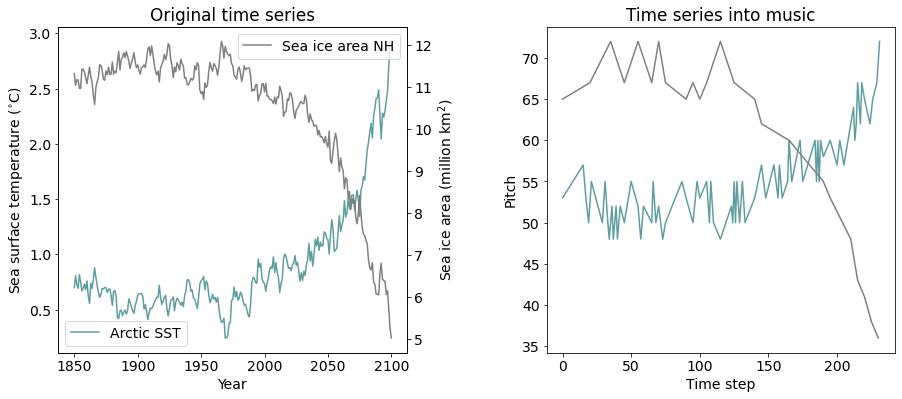

In [207]:
fig = plt.figure(figsize=(15,6))

ax = plt.subplot(121)
ax.plot(tos.year,tos.tos,color='cadetblue',label='Arctic SST')
ax.set_ylabel('Sea surface temperature ($^{\circ}$C)')
plt.legend(loc=3)
ax_ = ax.twinx()
ax_.plot(sia.year,sia.siarean,color='gray', label='Sea ice area NH')
ax.set_title('Original time series')
ax_.set_ylabel('Sea ice area (million km$^2$)')
ax.set_xlabel('Year')
plt.legend()

ax1 = plt.subplot(122)
ax1.plot(tosp.steps,tosp.note,color='cadetblue')
ax1.plot(bassline.steps,bassline.note,color='gray')
ax1.set_title('Time series into music')
ax1.set_ylabel('Pitch')
ax1.set_xlabel('Time step')

plt.subplots_adjust(wspace=0.4)
plt.show()

In [208]:
# save both tracks into csv files and then into a single MIDIp file
tosp.to_csv('tosp')
bassline.to_csv('siap')
to_midi(['tosp','siap'],'merged')

Music file merged.mid is playing!
Traceback (most recent call last):
  File "/Users/rlapere/Desktop/ERCA/functions.py", line 202, in launch_music
    play_music(music_file)
  File "/Users/rlapere/Desktop/ERCA/functions.py", line 187, in play_music
    clock.tick(30)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/rlapere/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/h_/dzgnf8cj0l9dnfqjjs8kk14w0000gn/T/ipykernel_51411/2890606420.py", line 1, in <module>
    launch_music('merged.mid')
  File "/Users/rlapere/Desktop/ERCA/functions.py", line 206, in launch_music
    raise SystemExit
SystemExit

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/rlapere/opt/anaconda3/lib/python3.9/site-packages/IPython/core/u

In [70]:
launch_music('merged.mid')

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
Music file merged.mid is playing!


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/rlapere/Desktop/ERCA/functions.py", line 202, in launch_music
    play_music(music_file)
  File "/Users/rlapere/Desktop/ERCA/functions.py", line 187, in play_music
    clock.tick(30)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/rlapere/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/h_/dzgnf8cj0l9dnfqjjs8kk14w0000gn/T/ipykernel_3251/2890606420.py", line 1, in <module>
    launch_music('merged.mid')
  File "/Users/rlapere/Desktop/ERCA/functions.py", line 206, in launch_music
    raise SystemExit
SystemExit

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/rlapere/opt/anaconda3/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1101, in get_recor

TypeError: object of type 'NoneType' has no len()

### CONGRATULATIONS! You just created your first climate song!

The result may not sound super cool just yet, but as you include more tracks and use an external midi software such as `GarageBand`, the result can be much nicer. As an example, below you can play a track I created with this script and `GarageBand` using zooplankton, arctic sea ice area and concentration, and sea surface temperature from `CMIP6`.

In [210]:
import vlc
p = vlc.MediaPlayer("arctic_ocean.mp3")
p.play()

0

In [211]:
p.stop()